#### Objetivo negocio: 
recomendar productos “similares” a los que un cliente ya compró, usando atributos del producto y señal de calidad (reviews).

In [2]:
# Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Detectar automáticamente la raíz del proyecto (donde existe la carpeta src)
PROJECT_DIR = Path.cwd().resolve()
while PROJECT_DIR != PROJECT_DIR.parent and not (PROJECT_DIR / "src").exists():
    PROJECT_DIR = PROJECT_DIR.parent
sys.path.insert(0, str(PROJECT_DIR))
from src.config import SEED
from src.utils.seeds import set_seeds
from src.paths import DATA_RAW, DATA_PROCESSED

## 1. Data collection

In [3]:
set_seeds(SEED)

# 1) Base de productos
products = pd.read_csv(DATA_RAW / "olist_products_dataset.csv")

# 2) Traduccion de categorias 
categories = pd.read_csv(DATA_RAW / "product_category_name_translation.csv")

# 3) Calidad Promedio
items = pd.read_csv(DATA_RAW / "olist_order_items_dataset.csv")
reviews = pd.read_csv(DATA_RAW / "olist_order_reviews_dataset.csv")

products.shape, categories.shape, items.shape, reviews.shape

((32951, 9), (71, 2), (112650, 7), (99224, 7))

## Eda minima

In [4]:
# EDA mínimo: ver columnas y missing
display(products.head())
categories.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [5]:
display(reviews.head())
items.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [6]:
# % de missing por columna (para decidir imputación)
display((products.isna().mean().sort_values(ascending=False)*100).head(15))
display((categories.isna().sum().sort_values(ascending=False)).head(15))

product_category_name         1.851234
product_description_lenght    1.851234
product_name_lenght           1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_height_cm             0.006070
product_length_cm             0.006070
product_width_cm              0.006070
product_id                    0.000000
dtype: float64

product_category_name            0
product_category_name_english    0
dtype: int64

In [7]:
# Unir traducción de categoría
prod = products.merge(categories, on="product_category_name", how="left")

#si no hay traducción, lo marcamos como Unknown para no perder filas
prod['product_category_name_english'] = prod['product_category_name_english'].fillna("Unknown")

prod.head()
prod[['product_id', 'product_category_name', 'product_category_name_english']].head()


,product_id,product_category_name,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


In [8]:
# promedio de review por orden (por si hay más de un review por order)
order_avg = (reviews.groupby('order_id')['review_score'].mean().reset_index(name="order_avg_review"))
order_avg

# unimos a items para llevar review a nivel item/producto
items_r = items.merge(order_avg, on='order_id', how='left')
items_r

# promedio por producto = proxy de calidad
prod_review = (items_r.groupby('product_id')['order_avg_review'].mean().reset_index(name='avg_review_score'))
prod_review.head()

,product_id,avg_review_score
0,00066f42aeeb9f3007548bb9d3f33c38,5.0
1,00088930e925c41fd95ebfe695fd2655,4.0
2,0009406fd7479715e4bef61dd91f2462,1.0
3,000b8f95fcb9e0096488278317764d19,5.0
4,000d9be29b5207b54e86aa1b1ac54872,5.0


In [9]:
# agregamos avg_review_score a los productos
data = prod.merge(prod_review, on='product_id', how='left')
data

missing = data.isna().sum().sort_values(ascending= False)
display(missing.to_frame("Datatos faltantes"))
data.info()

# Columnas a rellernar
num_cols = [
    "product_name_lenght",
    "product_description_lenght",
    "product_photos_qty",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
]

for c in num_cols:
    data[c] = data[c].fillna(data[c].median())

# si el producto nunca tuvo review, asumimos neutral = 3.0 (no premiar ni castigar)
data['avg_review_score'] = data['avg_review_score'].fillna(3.0)

# chequeo final de NaNs en lo que vamos a usar
missing = data.isna().sum().sort_values(ascending= False)
display(missing.to_frame("Datatos faltantes"))


,Datatos faltantes
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
avg_review_score,162
product_length_cm,2
product_weight_g,2
product_width_cm,2
product_height_cm,2
product_id,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32951 non-null  object 
 10  avg_review_score               32789 non-null  float64
dtypes: float64(8), object(3)
memory usage: 2.8+ MB


,Datatos faltantes
product_category_name,610
product_id,0
product_name_lenght,0
product_description_lenght,0
product_photos_qty,0
product_weight_g,0
product_length_cm,0
product_height_cm,0
product_width_cm,0
product_category_name_english,0


In [10]:
# Selección de features y tratamiento de categorías (mínimo)
cat_col = 'product_category_name_english'

top_n = 10
top_cats = data[cat_col].value_counts().nlargest(top_n).index.to_list()

# Las que no están en top_n se agrupan como "Other"
data["cat_top"] = data[cat_col].where(data[cat_col].isin(top_cats), other='other')

# One-hot encoding simple con pandas
cat_dummies = pd.get_dummies(data['cat_top'], prefix='cat')
cat_dummies.shape

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32951 non-null  float64
 3   product_description_lenght     32951 non-null  float64
 4   product_photos_qty             32951 non-null  float64
 5   product_weight_g               32951 non-null  float64
 6   product_length_cm              32951 non-null  float64
 7   product_height_cm              32951 non-null  float64
 8   product_width_cm               32951 non-null  float64
 9   product_category_name_english  32951 non-null  object 
 10  avg_review_score               32951 non-null  float64
 11  cat_top                        32951 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.0+ MB

In [11]:
# Escalado y matriz final
num_features = [
    "avg_review_score",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
    "product_photos_qty",
]

scaler = StandardScaler()
num_scaler = scaler.fit_transform(data[num_features])

# X final = numéricas escaladas + one-hot
X = np.hstack([num_scaler, cat_dummies.values])

X.shape

(32951, 17)

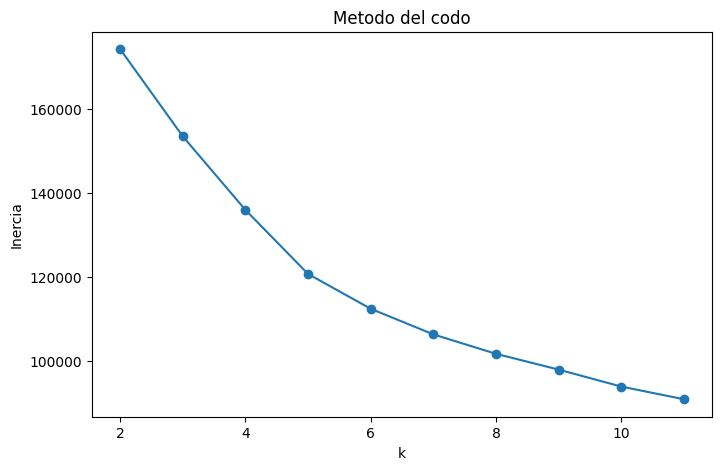

In [12]:
# Elegir K (mínimo: elbow + silhouette)
inertias = []
ks = range(2,12)

for k in ks:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(list(ks), inertias, marker="o")
plt.title("Metodo del codo")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.show()

In [13]:
K_final = 5

Kmeans = KMeans(n_clusters=K_final, random_state=SEED, n_init=10)
data['cluster'] = Kmeans.fit_predict(X)

sil_final = silhouette_score(X, data['cluster'])
print("K_FINAL:", K_final)
print("Silhouette final:", round(sil_final, 4))

data[["product_id","product_category_name_english","avg_review_score","cluster"]].head(10)

K_FINAL: 5
Silhouette final: 0.2152


,product_id,product_category_name_english,avg_review_score,cluster
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,5.000000,1
1,3aa071139cb16b67ca9e5dea641aaa2f,art,5.000000,1
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,5.000000,1
3,cef67bcfe19066a932b7673e239eb23d,baby,1.000000,2
4,9dc1a7de274444849c219cff195d0b71,housewares,5.000000,0
5,41d3672d4792049fa1779bb35283ed13,musical_instruments,5.000000,1
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,3.500000,4
7,2548af3e6e77a690cf3eb6368e9ab61e,furniture_decor,1.444444,2
8,37cc742be07708b53a98702e77a21a02,home_appliances,1.000000,2
9,8c92109888e8cdf9d66dc7e463025574,toys,4.000000,1


In [14]:
# Interpretación de clusters
cluster_summary = data.groupby('cluster')[num_features].mean()
cluster_sizes = data['cluster'].value_counts().sort_index()

cluster_summary['count'] = cluster_sizes.values
cluster_summary

,avg_review_score,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_photos_qty,count
cluster,,,,,,,
0,4.343000,1231.804158,26.425703,14.762343,19.847862,5.464210,4233
1,4.618630,766.044618,22.467746,13.792165,17.518412,1.506384,14882
2,1.941338,1091.971056,25.957813,14.941544,20.033106,1.688233,5286
3,4.324717,2979.585938,50.333386,16.624203,35.342474,1.909279,6272
4,3.822043,14896.517559,51.030290,47.020632,40.413082,2.176032,2278


In [15]:
# top categorías por cluster
top_cat_cluster = (data.groupby('cluster')['product_category_name_english'].apply(lambda s: s.value_counts().head(3)))

top_cat_cluster.to_frame("top_cat_cluster")

top_cat_cluster
cluster                                       
0       sports_leisure                     397
        auto                               365
        furniture_decor                    318
1       health_beauty                     1704
        sports_leisure                    1433
        computers_accessories              971
2       bed_bath_table                     603
        sports_leisure                     439
        furniture_decor                    425
3       bed_bath_table                    1438
        furniture_decor                   1074
        housewares                         508
4       office_furniture                   271
        housewares                         246
        furniture_decor                    241

In [16]:
# Recomendación mínima (Top-N dentro del cluster)
PRODUCT_IDS = set(data["product_id"])
def recommend_from_product (product_id: str, top_n: int = 10):
    """
    Recomendación mínima:
    - Ubicar el cluster del producto
    - Recomendar productos del mismo cluster
    - Ordenar por avg_review_score (calidad)
    """

    if product_id not in PRODUCT_IDS:
        return pd.DataFrame()

    cl = data.loc[data["product_id"] == product_id, "cluster"].iloc[0]

    recs = data.loc[
        (data["cluster"] == cl) & (data["product_id"] != product_id),  
        ["product_id", "product_category_name_english", "avg_review_score", "cluster"]]
    
    recs = recs.nlargest(top_n, "avg_review_score")

    return recs


In [26]:
# Demo

example_pid = data['product_id'].sample(1, random_state=SEED).iloc[0]
print("Producto base:", example_pid)

recs = recommend_from_product(example_pid, top_n=10)
recs

Producto base: f819f0c84a64f02d3a5606ca95edd272


,product_id,product_category_name_english,avg_review_score,cluster
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,5.0,1
1,3aa071139cb16b67ca9e5dea641aaa2f,art,5.0,1
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,5.0,1
5,41d3672d4792049fa1779bb35283ed13,musical_instruments,5.0,1
10,14aa47b7fe5c25522b47b4b29c98dcb9,bed_bath_table,5.0,1
12,cf55509ea8edaaac1d28fdb16e48fc22,musical_instruments,5.0,1
15,3bb7f144022e6732727d8d838a7b13b3,sports_leisure,5.0,1
17,a1b71017a84f92fd8da4aeefba108a24,computers_accessories,5.0,1
19,f53103a77d9cf245e579ea37e5ec51f0,bed_bath_table,5.0,1
23,8b41fbc2b984a12030090112324d1bc4,baby,5.0,1
